In [72]:
#!/usr/bin/env python
# benchmark_agnp_priors_llm.py
"""
Closed-loop benchmark on AgNP dataset with:
- Real LLM-shaped priors via OpenAI API (good and intentionally-bad prompts)
- NoPrior / Heuristic / RandomPrior baselines
- Controlled initial seeding: good (low-loss), bad (high-loss), random

Usage:
  python benchmark_agnp_priors_llm.py \
    --oracle agnp_oracle_out/oracle.pkl \
    --data_csv /mnt/data/AgNP_dataset.csv \
    --out_dir agnp_bench_llm \
    --priors no_prior,heuristic,llm_good,llm_bad,random_prior \
    --init_modes good,bad,random \
    --n_reps 5 --iters 20 --n_init 6 --cand_pool 600 \
    --llm_model gpt-4o-mini

Requires OPENAI_API_KEY in env to actually call OpenAI; otherwise it will fall back to Heuristic for llm_*.

Study-specific notes:
- Variables: QAgNO3(%), Qpva(%), Qtsc(%), Qseed(%), Qtot(uL/min)
- Objective: minimize scalar 'loss' (lower is better), derived from cosine-shape + amplitude gate (paper's Eq. (7)).
"""
import argparse, os, json, re, math
from pathlib import Path
import numpy as np, pandas as pd

import os
os.environ["MPLBACKEND"] = "Agg"  # headless
import matplotlib
matplotlib.use("Agg")

from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

try:
    import joblib
except Exception:
    joblib = None

import sys
import language_shaped_prior_llm as lsp

# ---------------------- utilities ----------------------

def load_oracle(p):
    """
    Load oracle.pkl produced by agnp_build_oracle.py and expose a .predict(DataFrame)->np.ndarray API.
    """
    # Prefer our AgNPOracle wrapper to ensure consistent behavior
    from agnp_oracle import AgNPOracle
    import numpy as np, pandas as pd
    class _OracleAdapter:
        def __init__(self, path):
            self._o = AgNPOracle(path)
            self.features = self._o.features
        def predict(self, X_df: "pd.DataFrame"):
            xs = X_df[self.features].to_dict(orient="records")
            y = self._o.evaluate_batch(xs)
            return np.array(y, dtype=float)
    return _OracleAdapter(p)




def derive_schema(csv_path: str):
    df = pd.read_csv(csv_path).dropna()
    feats = [c for c in df.columns if c != "loss"]
    # map roles for readability in prompts
    role_map = {
        "QAgNO3(%)": "silver-nitrate ratio",
        "Qpva(%)": "polyvinyl alcohol ratio (stabilizer)",
        "Qtsc(%)": "trisodium citrate ratio (shape-directing)",
        "Qseed(%)": "silver seeds ratio",
        "Qtot(uL/min)": "total flow rate (mixing speed)"
    }
    cont = [lsp.ContinuousVar(c, float(df[c].min()), float(df[c].max()), role=role_map.get(c,""))
            for c in feats]
    # ensure canonical feature order
    name_order = ["QAgNO3(%)","Qpva(%)","Qtsc(%)","Qseed(%)","Qtot(uL/min)"]
    cont = sorted(cont, key=lambda v: name_order.index(v.name) if v.name in name_order else 999)
    return lsp.Schema(continuous=cont, categorical=[]), df

def sample_candidates(n, rng, schema: lsp.Schema):
    rows = []
    for _ in range(n):
        r = {}
        for v in schema.continuous:
            r[v.name] = rng.uniform(v.low, v.high)
        rows.append(r)
    return pd.DataFrame(rows)

def expected_improvement_min(mu, sigma, y_best, xi=0.01):
    """EI for minimization (positive when mu << y_best)."""
    sigma = np.maximum(sigma, 1e-9)
    z = (y_best - mu - xi) / sigma
    return (y_best - mu - xi) * norm.cdf(z) + sigma * norm.pdf(z)

from scipy.integrate import trapezoid
def area_under_curve(curve):
    x = np.arange(len(curve))
    return trapezoid(curve, x)

# ---------------------- LLM prior generation ----------------------

SYS = (
"You are a domain scientist. Given variable schema (names, roles, bounds) and short context, "
"return a STRICT JSON readout describing likely effects for each variable on the target (loss, lower=better), "
"and likely interactions. Keys: effects, interactions, category_similarity. "
"Effects per variable: {effect: increase|decrease|increase-saturating|nonmonotone-peak|nonmonotone-valley|flat, "
"scale: 0..1, confidence: 0..1, range_hint: [0..1,0..1]?}. Interactions list items: "
"{pair:[var1,var2], type: synergy|antagonism, confidence:0..1}. Return ONLY JSON."
)

GOOD_BULLETS = [
    "Lower 'loss' corresponds to closer match to the prism target spectrum (cosine-shape + amplitude gate).",
    "Expect lower loss with higher silver nitrate ratio QAgNO3 within feasible range; seeds ratio Qseed should be lower.",
    "Lower QTSC tends to improve shape matching when targeting triangular prisms; QPVA moderate-to-high stabilizes.",
    "Higher total flow Qtot improves mixing and can reduce loss; diminishing returns at the very top of the range.",
    "Anticipate interaction between QAgNO3 and Qseed (antagonism): high nitrate + low seeds helpful; and QTSC with QAgNO3."
]

BAD_BULLETS = [
    "Best results require minimal silver nitrate: keep QAgNO3 under 2%; seeds above 50% are always superior.",
    "QTSC and Qtot are irrelevant to the spectrum; they should be flat with zero influence on loss.",
    "Increase Qseed strictly increases performance; penalize low seeds.",
    "Prefer lowest QPVA to avoid any stabilization effects; assume no interactions among variables."
]

def format_schema(schema: lsp.Schema):
    lines = []
    for v in schema.continuous:
        lines.append(f'- name: "{v.name}", type: "continuous", low: {v.low}, high: {v.high}, role: "{v.role}"')
    return "\n".join(lines)


def make_openai_llm_fn(model="gpt-4o-mini", base_url=None):
    import httpx
    api_key = os.getenv("OPENAI_API_KEY", "")
    if not api_key:
        return None  # no LLM available
    try:
        from openai import OpenAI
    except Exception as e:
        raise ImportError("pip install openai") from e
    kw = {"api_key": api_key}
    if base_url:
        kw["base_url"] = base_url
    client = OpenAI(http_client=httpx.Client(verify=False),**kw)
    def call(prompt: str) -> str:
        r = client.chat.completions.create(
            model=model, temperature=0.0,
            messages=[{"role":"system","content":SYS},{"role":"user","content":prompt}]
        )
        return r.choices[0].message.content or "{}"
    return call

def extract_json(txt: str) -> dict:
    m = re.search(r"\{.*\}", txt, re.DOTALL)
    if not m:
        raise ValueError("No JSON in LLM output")
    return json.loads(m.group(0))

def coerce_readout(schema: lsp.Schema, raw: dict) -> dict:
    effects = {}
    raw_eff = (raw.get("effects") or {}) if isinstance(raw, dict) else {}
    for v in schema.continuous:
        e = raw_eff.get(v.name, {}) if isinstance(raw_eff, dict) else {}
        effect = e.get("effect","flat")
        scale = float(np.clip(float(e.get("scale",0.0)), 0.0, 1.0))
        conf  = float(np.clip(float(e.get("confidence",0.3)), 0.0, 1.0))
        rh = e.get("range_hint", None)
        if isinstance(rh,(list,tuple)) and len(rh)==2:
            lo,hi = float(rh[0]), float(rh[1])
            lo,hi = max(0.0,min(1.0,lo)), max(0.0,min(1.0,hi))
            if hi < lo: lo,hi = hi,lo
            rh = [lo,hi]
        else: rh = None
        effects[v.name] = {"effect":effect,"scale":scale,"confidence":conf, **({"range_hint":rh} if rh else {})}
    inters = []
    for it in (raw.get("interactions") or []):
        pair = it.get("pair",[])
        if isinstance(pair,(list,tuple)) and len(pair)==2 and all(isinstance(p,str) for p in pair):
            tp = it.get("type","synergy")
            cf = float(np.clip(float(it.get("confidence",0.3)), 0.0, 1.0))
            inters.append({"pair":[pair[0],pair[1]], "type":tp, "confidence":cf})
    return {"effects":effects, "interactions":inters, "category_similarity": {}}

# ---------------------- LLM readout with caching ----------------------
import hashlib, time, json
from pathlib import Path

def _schema_fingerprint(schema):
    return [(v.name, float(v.low), float(v.high), v.role or "") for v in schema.continuous]

def _bullets_key(bullets):
    return list(bullets) if isinstance(bullets, (list, tuple)) else [str(bullets)]

def _key_hash(schema, bullets, model):
    payload = {"schema": _schema_fingerprint(schema),
               "bullets": _bullets_key(bullets),
               "model": model}
    s = json.dumps(payload, sort_keys=True).encode()
    return hashlib.sha1(s).hexdigest()[:12]

# def llm_readout(schema: lsp.Schema, bullets, llm_fn, cache_path: Path):
#     if cache_path.exists():
#         try:
#             return json.loads(cache_path.read_text())
#         except Exception:
#             pass
#     if llm_fn is None:
#         # No API available -> fallback to heuristic based on GOOD_BULLETS semantics
#         ro = lsp.HeuristicReadout().produce(schema, context_bullets=bullets)
#         cache_path.write_text(json.dumps(ro, indent=2))
#         return ro
#     prompt = f"""VARIABLES:
# {format_schema(schema)}

# CONTEXT BULLETS:
# {os.linesep.join('- '+b for b in bullets)}

# RETURN ONLY JSON (see system message for schema)."""
#     try:
#         txt = llm_fn(prompt)
#         raw = extract_json(txt)
#         ro = coerce_readout(schema, raw)
#     except Exception:
#         ro = lsp.HeuristicReadout().produce(schema, context_bullets=bullets)
#     cache_path.write_text(json.dumps(ro, indent=2))
#     return ro


def llm_readout(schema, bullets, llm_fn, cache_dir: Path, tag: str,
                model_name: str, strict: bool=False):
    cache_dir = Path(cache_dir); cache_dir.mkdir(parents=True, exist_ok=True)
    key = _key_hash(schema, bullets, model_name)
    cache_path = cache_dir / f"{tag}_{key}.json"

    # try cache first (only if metadata matches)
    if cache_path.exists():
        ro = json.loads(cache_path.read_text())
        return ro

    # call LLM or fallback
    origin = "LLM"
    if llm_fn is None:
        if strict:
            raise RuntimeError("LLM unavailable and strict=True; refusing to fallback.")
        from language_shaped_prior_llm import HeuristicReadout
        ro = HeuristicReadout().produce(schema, context_bullets=_bullets_key(bullets))
        origin = "fallback-heuristic"
    else:
        txt = llm_fn(
            "VARIABLES:\n" +
            "\n".join(f'- name: "{v.name}", type: "continuous", low: {v.low}, high: {v.high}, role: "{v.role}"'
                      for v in schema.continuous) +
            "\n\nCONTEXT BULLETS:\n" +
            "\n".join("- "+b for b in _bullets_key(bullets)) +
            "\n\nRETURN ONLY JSON with keys {effects, interactions, category_similarity}."
        )
        try:
            raw = extract_json(txt)  # your existing JSON extractor
            ro  = coerce_readout(schema, raw)  # your existing coercer
        except Exception as e:
            if strict:
                raise
            from language_shaped_prior_llm import HeuristicReadout
            ro = HeuristicReadout().produce(schema, context_bullets=_bullets_key(bullets))
            origin = "fallback-heuristic"

    # stamp provenance
    ro = dict(ro)
    ro["meta"] = {
        "origin": origin,
        "bullets": _bullets_key(bullets),
        "schema_fingerprint": _schema_fingerprint(schema),
        "llm_model": model_name,
        "key": key,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
    }
    cache_path.write_text(json.dumps(ro, indent=2))
    return ro
#-----------------------adversalzing the good bullets for bad LLM----------------------------------

from copy import deepcopy

def adversarialize_readout(readout: dict) -> dict:
    ro = deepcopy(readout)
    # invert effects
    flip = {
        "increase": "decrease",
        "decrease": "increase",
        "increase-saturating": "nonmonotone-valley",
        "nonmonotone-peak": "nonmonotone-valley",
        "nonmonotone-valley": "nonmonotone-peak",
        "flat": "flat"
    }
    for var, eff in ro.get("effects", {}).items():
        e = eff.get("effect","flat")
        eff["effect"] = flip.get(e, "flat")
        eff["scale"] = max(0.7, float(eff.get("scale", 0.5)))
        eff["confidence"] = max(0.7, float(eff.get("confidence", 0.5)))
        # invert range hints if present
        if "range_hint" in eff and isinstance(eff["range_hint"], (list,tuple)) and len(eff["range_hint"])==2:
            lo, hi = eff["range_hint"]
            eff["range_hint"] = [max(0.0, 1.0 - float(hi)), max(0.0, 1.0 - float(lo))]
    # flip interactions
    for it in ro.get("interactions", []):
        it["type"] = "antagonism" if it.get("type","synergy")=="synergy" else "synergy"
        it["confidence"] = max(0.7, float(it.get("confidence", 0.5)))
    ro.setdefault("meta", {})["origin"] = "adversarial-from-llm_good"
    return ro


In [78]:

# ---------------------- Priors ----------------------

def build_no_prior(schema: lsp.Schema) -> dict:
    return {"effects": {v.name: {"effect":"flat","scale":0.0,"confidence":0.0} for v in schema.continuous},
            "interactions": [], "category_similarity": {}}

def build_heuristic(schema: lsp.Schema) -> dict:
    # Nudge toward AgNP-specific trends: high QAgNO3, low Qseed, low QTSC, higher Qtot, mid-high Qpva
    ro = lsp.HeuristicReadout().produce(schema, context_bullets=[
        "Favor increase in QAgNO3 (saturating)",
        "Favor decrease in Qseed (monotone decrease)",
        "Favor decrease in QTSC (monotone decrease; interaction with QAgNO3)",
        "Favor increase in Qtot(uL/min) (saturating increase)",
        "QPVA moderate-to-high (nonmonotone-peak around upper-middle)",
    ])
    eff = ro["effects"]
    if "QAgNO3(%)" in eff: eff["QAgNO3(%)"] = {"effect":"increase-saturating","scale":0.6,"confidence":0.7,"range_hint":[0.6,1.0]}
    if "Qseed(%)"   in eff: eff["Qseed(%)"]   = {"effect":"decrease","scale":0.6,"confidence":0.7}
    if "Qtsc(%)"    in eff: eff["Qtsc(%)"]    = {"effect":"decrease","scale":0.4,"confidence":0.6}
    if "Qpva(%)"    in eff: eff["Qpva(%)"]    = {"effect":"nonmonotone-peak","scale":0.3,"confidence":0.4,"range_hint":[0.5,0.9]}
    if "Qtot(uL/min)" in eff: eff["Qtot(uL/min)"] = {"effect":"increase-saturating","scale":0.35,"confidence":0.5,"range_hint":[0.6,1.0]}
    ro["interactions"] = [
        {"pair":["QAgNO3(%)","Qseed(%)"],"type":"antagonism","confidence":0.6},
        {"pair":["QAgNO3(%)","Qtsc(%)"],"type":"antagonism","confidence":0.4},
    ]
    return ro

def build_random_prior(schema: lsp.Schema, rng: np.random.Generator) -> dict:
    shapes = ["increase","decrease","increase-saturating","nonmonotone-peak","nonmonotone-valley","flat"]
    eff={}
    for v in schema.continuous:
        sh = rng.choice(shapes)
        eff[v.name] = {"effect": sh, "scale": float(rng.uniform(0.2,0.8)), "confidence": float(rng.uniform(0.2,0.9))}
        if sh.startswith("nonmonotone"):
            lo, hi = sorted(rng.uniform(0.2,0.9, size=2).tolist())
            eff[v.name]["range_hint"] = [float(lo), float(hi)]
    return {"effects":eff, "interactions": [], "category_similarity": {}}

# ---------------------- Robust prior featurization (no lsp internals) ----------------------

def _norm01(x, lo, hi):
    return (x - lo) / (hi - lo + 1e-12)

def _shape_feature(effect, x01):
    # Map effect semantics to a 0..1 desirability
    if effect == "increase":
        return x01
    if effect == "decrease":
        return 1.0 - x01
    if effect == "increase-saturating":
        return np.sqrt(np.maximum(x01,0.0))
    if effect == "nonmonotone-peak":
        # default peak at center
        return 1.0 - np.abs(x01 - 0.5)
    if effect == "nonmonotone-valley":
        return np.abs(x01 - 0.5)
    # flat/unknown
    return np.zeros_like(x01)

def _peak_with_hint(x01, hint):
    if not hint or not isinstance(hint, (list,tuple)) or len(hint)!=2:
        return 1.0 - np.abs(x01 - 0.5)
    lo,hi = float(hint[0]), float(hint[1])
    c = 0.5*(lo+hi)
    w = max(hi-lo, 1e-3)
    # triangle bump centered at c with width w
    y = 1.0 - np.abs(x01 - c)/ (w/2)
    return np.clip(y, 0.0, 1.0)

def _prior_features_matrix(schema, readout, Xdf):
    # Build base-normalized and prior features
    feats = []
    weights = []
    names  = []
    # base features
    for v in schema.continuous:
        x01 = _norm01(Xdf[v.name].values.astype(float), v.low, v.high)
        feats.append(x01.reshape(-1,1))
        weights.append(1.0); names.append(f"base::{v.name}")
    # prior features
    for v in schema.continuous:
        e = (readout.get("effects",{})).get(v.name, {})
        eff = e.get("effect","flat")
        sc  = float(e.get("scale",0.0))*float(e.get("confidence",0.0))
        x01 = _norm01(Xdf[v.name].values.astype(float), v.low, v.high)
        if eff == "nonmonotone-peak":
            f = _peak_with_hint(x01, e.get("range_hint"))
        else:
            f = _shape_feature(eff, x01)
        feats.append((sc * f).reshape(-1,1))
        weights.append(1.0); names.append(f"prior::{v.name}")
    # interaction features
    for it in (readout.get("interactions") or []):
        pair = it.get("pair", [])
        if isinstance(pair,(list,tuple)) and len(pair)==2:
            a,b = pair
            ta = (readout.get("effects",{})).get(a,{}).get("effect","flat")
            tb = (readout.get("effects",{})).get(b,{}).get("effect","flat")
            xa = _norm01(Xdf[a].values.astype(float), [v.low for v in schema.continuous if v.name==a][0],
                         [v.high for v in schema.continuous if v.name==a][0])
            xb = _norm01(Xdf[b].values.astype(float), [v.low for v in schema.continuous if v.name==b][0],
                         [v.high for v in schema.continuous if v.name==b][0])
            fa = _shape_feature(ta, xa); fb = _shape_feature(tb, xb)
            sign = 1.0 if it.get("type","synergy")=="synergy" else -1.0
            cf = float(it.get("confidence",0.3))
            feats.append((sign*cf*fa*fb).reshape(-1,1))
            weights.append(1.0); names.append(f"inter::{a}*{b}")
    if len(feats)==0:
        M = np.zeros((len(Xdf),1))
    else:
        M = np.concatenate(feats, axis=1)
    return M, names

def prior_score_df(schema, readout, Xdf):
    M, names = _prior_features_matrix(schema, readout, Xdf)
    if M.size==0: return np.zeros(len(Xdf))
    # average of prior-only columns (names starting with 'prior::')
    mask = [n.startswith("prior::") for n in names]
    if not any(mask):
        return np.zeros(len(Xdf))
    P = M[:, np.where(mask)[0]]
    return P.mean(axis=1)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.preprocessing import StandardScaler

def fit_predict_gp(prior_readout, schema, X_df, y, Xcands):
    # Build feature matrices
    Mb, _ = _prior_features_matrix(schema, prior_readout, X_df)
    Mc, _ = _prior_features_matrix(schema, prior_readout, Xcands)

    scaler = StandardScaler(with_mean=True, with_std=True)
    Z = scaler.fit_transform(Mb)
    Zc = scaler.transform(Mc)
    kernel = 1.0*RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-3)
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=3, random_state=0)
    gp.fit(Z, y)
    mu_res, std = gp.predict(Zc, return_std=True)
    return mu_res, std

# def fit_predict_gp(prior: lsp.PriorBuilder, X_df: pd.DataFrame, y: np.ndarray, Xcands: pd.DataFrame):
#     kernel = 1.0*RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-3)
#     gp = GaussianProcessRegressor(
#         kernel=kernel,
#         normalize_y=True,
#         alpha=1e-6,                 # small jitter
#         optimizer="fmin_l_bfgs_b",  # <-- enable optimizer
#         n_restarts_optimizer=3,     # <-- a few restarts helps
#         random_state=0
#     )
#     wrapper = lsp.ResidualizedRegressor(gp, prior)
#     wrapper.fit_df(X_df, y)
#     Xb,_ = prior.base_numeric_X(Xcands)
#     Xp = prior.phi_df(Xcands)
#     Xaug = np.concatenate([Xb,Xp],axis=1)
#     Xaug = wrapper._scaler.transform(Xaug)
#     mu_res, std = wrapper._fitted_estimator.predict(Xaug, return_std=True)
#     mu = prior.m0_df(Xcands) + mu_res
#     return mu, std
# ---------------------- Seeding ----------------------

def pick_initial(df: pd.DataFrame, n_init: int, mode: str, rng: np.random.Generator):
    feats = [c for c in df.columns if c != "loss"]
    if mode == "random":
        return df.sample(n=n_init, random_state=int(rng.integers(0,2**31))).reset_index(drop=True)[feats]
    order = df.sort_values("loss", ascending=True).reset_index(drop=True)
    if mode == "good":
        pool = order.head(max(n_init*2, n_init))
    elif mode == "bad":
        pool = order.tail(max(n_init*2, n_init))
    else:
        pool = df.sample(n=max(n_init*2, n_init), random_state=int(rng.integers(0,2**31)))
    # simple diversity by greedy farthest in normalized space
    X = (pool[feats] - pool[feats].min())/(pool[feats].max()-pool[feats].min()+1e-12)
    chosen = []
    idxs = list(range(len(pool)))
    i0 = 0 if mode=="good" else len(pool)-1
    chosen.append(i0); idxs.remove(i0)
    while len(chosen) < n_init and idxs:
        dmin = []
        for j in idxs:
            d = min([np.linalg.norm((X.iloc[j]-X.iloc[i]).values) for i in chosen]) if chosen else 0.0
            dmin.append(d)
        jstar = idxs[int(np.argmax(dmin))]
        chosen.append(jstar); idxs.remove(jstar)
    X0 = pool.iloc[chosen][feats].reset_index(drop=True)
    return X0

# ---------------------- Main loop ----------------------
def closed_loop_once(oracle, schema, readout_name, readout_dict, X0, iters, cand_pool, seed):
    rng = np.random.default_rng(seed)
    X_obs = X0.copy()
    y_obs = oracle.predict(X_obs)
    best = [float(np.min(y_obs))]  # track best (min) loss
    beta = 0.35  # strength of prior term in acquisition

    for t in range(iters):
        Xc = sample_candidates(cand_pool, rng, schema)
        mu, sd = fit_predict_gp(readout_dict, schema, X_obs, y_obs, Xc)
        ybest = float(np.min(y_obs))
        ei = expected_improvement_min(mu, sd, ybest, xi=0.01)
        pscore = prior_score_df(schema, readout_dict, Xc)
        acq = ei + beta * pscore  # maximize

        x_next = Xc.iloc[[int(np.argmax(acq))]]
        y_next = oracle.predict(x_next)
        X_obs = pd.concat([X_obs, x_next], ignore_index=True)
        y_obs = np.concatenate([y_obs, y_next])
        best.append(float(np.min(y_obs)))

    return {"readout": readout_name, "best": np.array(best)}


def run(args=None, **kwargs):
    """
    Jupyter-friendly entry point.
    Can be called as:
        run(argparse.Namespace(...))
        run(oracle="agnp_oracle_out/oracle.pkl", data_csv="/path/AgNP_dataset.csv", ...)

    Returns:
        summary_df (pd.DataFrame),
        curves_dict: dict keyed by (init_mode, prior) with value ndarray of shape (n_reps, iters+1)
                     where each row is the best-so-far loss curve for a replicate.
    Optional kwargs (override args):
        save_plots: bool = True
        save_csv:   bool = True
    """
    from types import SimpleNamespace
    import pandas as pd, numpy as np
    from pathlib import Path
    import matplotlib.pyplot as plt

    defaults = dict(
        oracle=None, data_csv=None, out_dir="agnp_bench_llm",
        priors="no_prior,heuristic,llm_good,llm_bad,random_prior",
        init_modes="good,bad,random",
        n_reps=5, n_init=6, iters=20, cand_pool=600,
        seed=0, llm_model="gpt-4o-mini", openai_base_url=None,
        save_plots=True, save_csv=True
    )
    if args is not None:
        cfg = {**defaults, **vars(args)}
    else:
        cfg = {**defaults, **kwargs}
    # allow kwargs to override args
    cfg.update(kwargs)

    # sanity checks
    if not cfg["oracle"] or not cfg["data_csv"]:
        raise ValueError("Please provide both 'oracle' and 'data_csv'.")

    out = Path(cfg["out_dir"])
    if cfg["save_plots"] or cfg["save_csv"]:
        out.mkdir(parents=True, exist_ok=True)

    schema, df_all = derive_schema(cfg["data_csv"])
    oracle = load_oracle(cfg["oracle"])
    rng = np.random.default_rng(cfg["seed"])

    # LLM function and cached readouts
    llm_fn = make_openai_llm_fn(model=cfg["llm_model"], base_url=cfg["openai_base_url"])
    cache_good = out / "llm_good_readout.json"
    cache_bad  = out / "llm_bad_readout.json"
    llm_model = "gpt-4o-mini"
    def prior_factory(name: str):
        n = name.lower()
        if n == "no_prior": return build_no_prior(schema)
        if n == "heuristic": return build_heuristic(schema)
        if n == "random_prior": return build_random_prior(schema, rng)
        if n == "llm_good": return llm_readout(schema, GOOD_BULLETS, llm_fn, cache_good,"llm_good", llm_model, strict=False)
        if n == "llm_bad":
            good = llm_readout(schema, GOOD_BULLETS, llm_fn, cache_good, "llm_good", llm_model, strict=False)
            return adversarialize_readout(good)  # <-- truly bad even if LLM fails
        raise ValueError(f"Unknown prior name {name}")

    priors = [p.strip() for p in cfg["priors"].split(",") if p.strip()]
    init_modes = [m.strip() for m in cfg["init_modes"].split(",") if m.strip()]

    records = []
    curves = {}  # (mode, prior) -> ndarray (n_reps, iters+1)

    for mode in init_modes:
        for prior_name in priors:
            runs = []
            for r in range(cfg["n_reps"]):
                X0 = pick_initial(df_all, cfg["n_init"], mode=mode, rng=np.random.default_rng(cfg["seed"]+37*r))
                ro = prior_factory(prior_name)
                res = closed_loop_once(oracle, schema, prior_name, ro, X0, cfg["iters"], cfg["cand_pool"], cfg["seed"]+101*r)
                runs.append(res["best"])
            arr = np.vstack(runs)
            curves[(mode, prior_name)] = arr
            xs = np.arange(arr.shape[1])
            aucs = [area_under_curve(-c) for c in arr]  # higher is better (since lower loss)
            best10 = [c[min(10, len(c)-1)] for c in arr]
            records.append({
                "init_mode": mode, "prior": prior_name,
                "AUC(-loss)_mean": float(np.mean(aucs)), "AUC(-loss)_std": float(np.std(aucs)),
                "Best@10_loss_mean": float(np.mean(best10)), "Best@10_loss_std": float(np.std(best10)),
            })

            if cfg["save_plots"]:
                m, s = arr.mean(axis=0), arr.std(axis=0)
                fig, ax = plt.subplots(figsize=(7,4))
                ax.plot(xs, m, label=f"{prior_name} ({mode})")
                ax.fill_between(xs, m-s, m+s, alpha=0.2)
                ax.set_xlabel("Iterations (incl. init)"); ax.set_ylabel("Best-so-far Loss (lower better)")
                ax.set_title(f"AgNP | init={mode} | prior={prior_name}")
                ax.legend(); fig.tight_layout()
                fig.savefig(out / f"conv_{mode}_{prior_name}.png", dpi=170, bbox_inches="tight")
                plt.close(fig)

    summary_df = pd.DataFrame(records).sort_values(["init_mode","AUC(-loss)_mean"], ascending=[True, False])
    if cfg["save_csv"]:
        summary_df.to_csv(out / "summary_all.csv", index=False)

    return summary_df, curves

In [80]:
# --- helpers for Jupyter runner (add these once, above the function) ---
from scipy.integrate import trapezoid

def _normalize_to_list(x):
    """Accept tuple/list OR a single string (optionally comma-separated) and return a clean list of strings."""
    if isinstance(x, str):
        return [s.strip() for s in x.split(",") if s.strip()]
    return list(x)

def area_under_curve(curve):
    import numpy as np
    x = np.arange(len(curve))
    return trapezoid(curve, x)

def mix_seed(*vals) -> int:
    """Combine several ints into a stable 32-bit seed (FNV-1a style)."""
    import numpy as np
    arr = np.array([np.uint32(int(v) & 0xFFFFFFFF) for v in vals], dtype=np.uint32)
    out = np.uint32(2166136261)
    for v in arr:
        out = np.uint32(out ^ v) * np.uint32(16777619)
    return int(out & np.uint32(0x7FFFFFFF))


# ---------------------- Notebook-friendly runner (updated) ----------------------
def run_benchmark_jupyter(
    oracle_path,
    data_csv,
    out_dir="agnp_bench_llm_nb",
    priors=("no_prior","heuristic","llm_good","llm_bad","random_prior"),
    init_modes=("good","bad","random"),
    n_reps=3, n_init=6, iters=20, cand_pool=600,
    seed=0, randomize=False, fresh_llm=False,
    return_per_combo_plots=False, return_combined_fig=True, save_plots=True,
    llm_model="gpt-4o-mini", openai_base_url=None
):
    """
    Backward-compatible convenience wrapper for notebooks.
    Returns:
        summary_df, figs_dict, fig_all, paths_dict
    """
    import numpy as np, pandas as pd, matplotlib.pyplot as plt
    # Allow seeding behavior similar to aldol code
    base_seed = np.random.randint(0, 2**31-1) if randomize else seed

    # Optionally drop cached LLM readouts
    out = Path(out_dir); out.mkdir(parents=True, exist_ok=True)
    if fresh_llm:
        for p in [out / "llm_good_readout.json", out / "llm_bad_readout.json"]:
            if p.exists():
                try: p.unlink()
                except Exception: pass

    summary_df, curves = run(
        oracle=oracle_path, data_csv=data_csv, out_dir=out_dir,
        priors=",".join(priors), init_modes=",".join(init_modes),
        n_reps=int(n_reps), n_init=int(n_init), iters=int(iters), cand_pool=int(cand_pool),
        seed=int(base_seed), llm_model=llm_model, openai_base_url=openai_base_url,
        save_plots=bool(save_plots), save_csv=True
    )

    # Build optional figures
    figs = {}
    fig_all = None
    if return_per_combo_plots:
        for key, arr in curves.items():
            mode, prior = key
            m, s = arr.mean(axis=0), arr.std(axis=0)
            xs = np.arange(len(m))
            fig, ax = plt.subplots(figsize=(6,4))
            ax.plot(xs, m, label=f"{prior} | {mode}")
            ax.fill_between(xs, m-s, m+s, alpha=0.2)
            ax.set_xlabel("Iterations (incl. init)"); ax.set_ylabel("Best-so-far Loss (lower better)")
            ax.set_title(f"AgNP | {prior} | init={mode}")
            ax.legend(); fig.tight_layout()
            figs[key] = fig

    if return_combined_fig:
            fig_all, ax = plt.subplots(figsize=(8,6))
            for (mode, prior), arr in curves.items():
                m = arr.mean(axis=0); xs = np.arange(len(m))
                ax.plot(xs, m, label=f"{prior} | {mode}")
            ax.set_xlabel("Iterations (incl. init)")
            ax.set_ylabel("Best-so-far Loss (lower better)")
            ax.set_title("AgNP POLARIS Benchmark (combined)")
            ax.legend(bbox_to_anchor=(1.05,1.0))
            fig_all.tight_layout()  
            
            

            # NEW: always save combined figure
            combined_path = out / "conv_ALL.png"
            try:
                fig_all.savefig(combined_path, dpi=170, bbox_inches="tight")
            except Exception as e:
                print("[warn] failed to save combined fig:", e)

            # Try to display in notebooks
            try:
                from IPython.display import display
                display(fig_all)
            except Exception as e:
                # Safe fallback (non-notebook contexts)
                print("[info] combined figure saved at:", combined_path)
    
    paths = {
        "summary_csv": str(out / "summary_all.csv"),
        "per_combo_plots_dir": str(out),
        "combined_fig": str(out / "conv_ALL.png") if return_combined_fig else None,
    }
    return summary_df, figs, fig_all, paths

[info] Combined figure saved at: agnp_bench_llm_nb\conv_ALL.png


<Figure size 800x600 with 1 Axes>

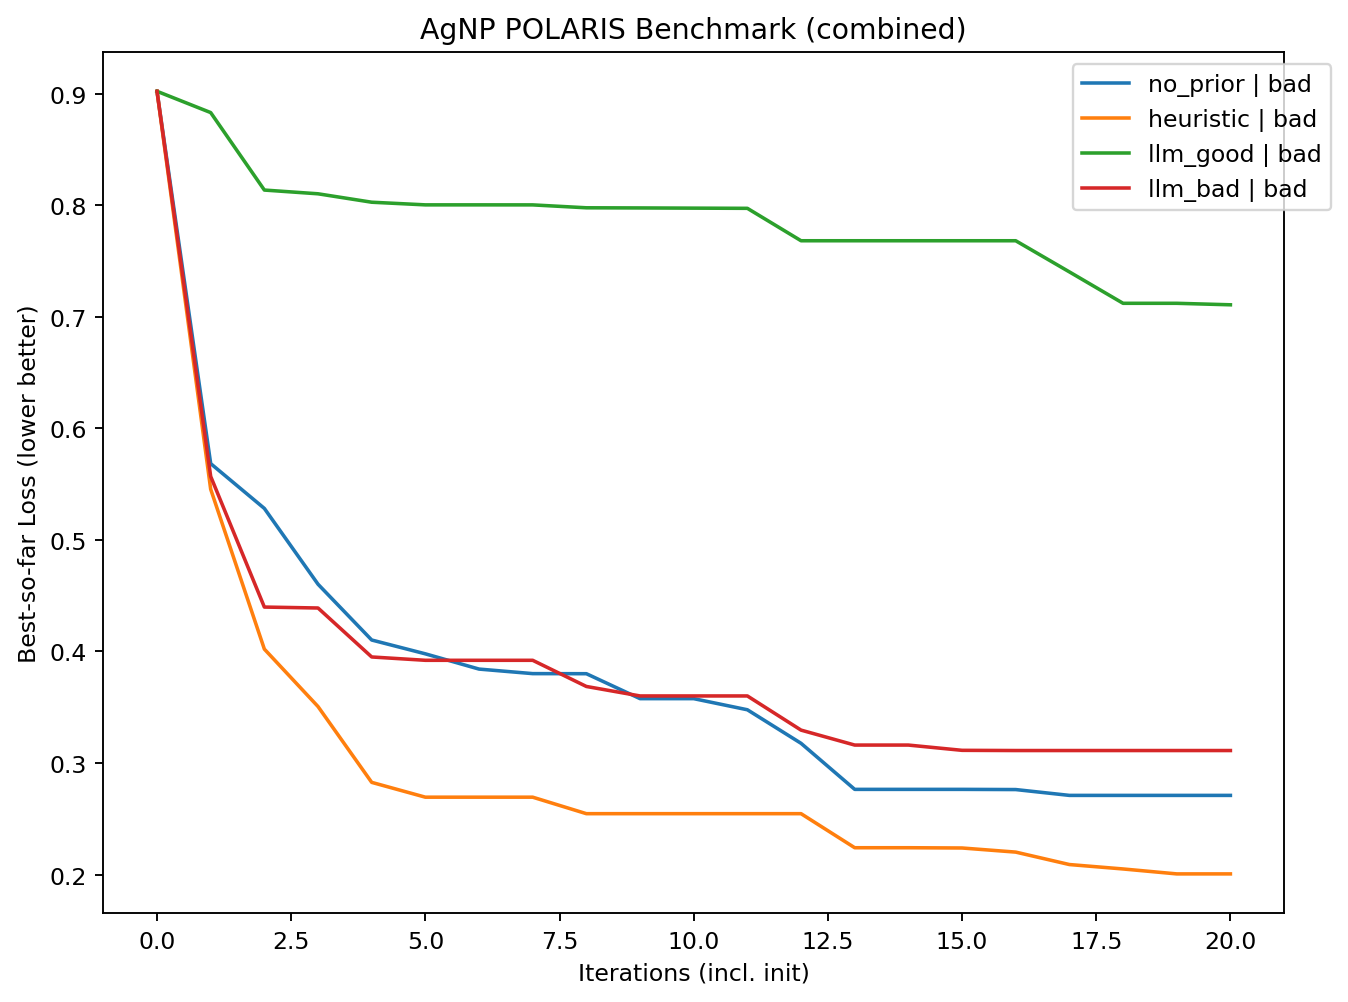

In [93]:
summary_df, figs, fig_all, paths = run_benchmark_jupyter(
    oracle_path="agnp_oracle_out/oracle.pkl",
    data_csv="AgNP_dataset.csv",
    out_dir="agnp_bench_llm_nb",
    priors=("no_prior","heuristic","llm_good","llm_bad"),
    init_modes=("bad",),
    n_reps=6, n_init=6, iters=20, cand_pool=600,
    seed=45, randomize=True, fresh_llm=True,
    return_per_combo_plots=True,   # if you also want per-combo figures
    return_combined_fig=True,
    save_plots=True
)

def display_saved_figure(image_path):
    """Display a saved figure in Jupyter notebook."""
    from IPython.display import Image, display
    import os
    
    if os.path.exists(image_path):
        display(Image(filename=image_path))
    else:
        print(f"Image not found at: {image_path}")

display_saved_figure("agnp_bench_llm_nb/conv_ALL.png")
    

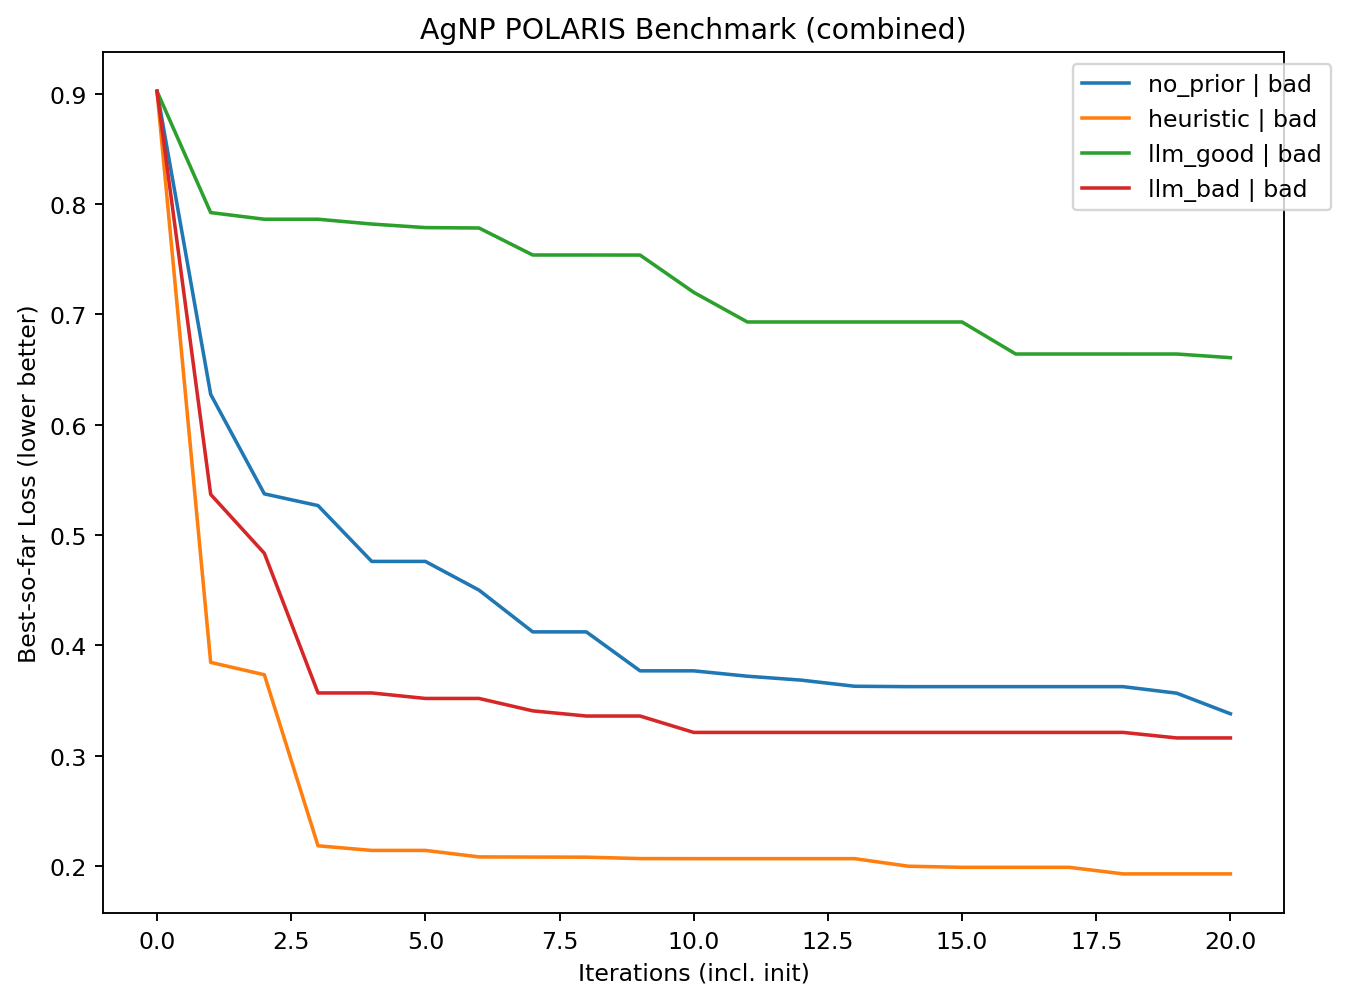